<a href="https://colab.research.google.com/github/bellajelly/week4-data-exploration-ml/blob/main/Feature_Engineering_and_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

In this notebook I am predicting wine cultivar from the Wine dataset.
But accuracy here is relative — the model can only learn within
the boundaries of the labels and features I give it. A high
accuracy score means the model is good at predicting my
operationalization of the target, not necessarily the
underlying cultivar genetic footprint and regulatory decisions made during grape development and fermentation.

##Hypothesis
Based on preliminary data analysis, I predict proline will be the most discriminating feature because it acts as a convergence point in the causal chain from grape genetics through fermentation to final chemical
composition. Like integrator nodes in a gene regulatory
network, features that accumulate signals from multiple
upstream sources tend to carry more discriminating information
than purely upstream or downstream features.

However, which features matter most likely depends on the
question being asked. Upstream features like alkalinity of
ash may better capture geological and genetic origin, while
convergent features like proline better capture the full
biological process.

##Visualization Interpretation
Proline shows the strongest separation between cultivars —
cultivar 0 has a median around 1100 mg/L, sitting in a
completely different range from cultivars 1 and 2. A boundary
around 800 mg/L could meaningfully separate cultivar 0 from
the others.

Alkalinity of ash shows greater difference in means across
cultivars but substantial box overlap, making it less useful
as a single discriminating feature.

This confirms the hypothesis that convergent features
integrating multiple upstream signals carry more discriminating
information than purely upstream geological features.

## Feature Engineering
I created a new categorical feature 'proline_bin' based on
biologically motivated boundaries identified from the boxplot
visualization. The boundaries at 600 and 800 mg/L correspond
to the upper quartile separation between cultivars 1 and 2,
and the clear distributional separation between cultivar 0
and the others respectively.

These bins reflect three distinct nitrogen metabolism states:
- Below 600: nutrient deficiency
- 600-800: nutrient equilibrium  
- Above 800: nutrient stress


In [7]:
from sklearn.datasets import load_wine
import pandas as pd
import matplotlib.pyplot as plt

# I load the dataset
wine = load_wine()

# I turn it into a dataframe so it's readable
dataFrame = pd.DataFrame(wine.data, columns=wine.feature_names)
dataFrame['target'] = wine.target

# I look at the first few rows
dataFrame.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
# What are the three classes?
print(wine.target_names)

#Samples per class?
print(pd.Series(wine.target).value_counts().sort_index())

# Get a feel for the scale of each feature
dataFrame.describe()

print(dataFrame.shape)

['class_0' 'class_1' 'class_2']
0    59
1    71
2    48
Name: count, dtype: int64
(178, 14)


In [6]:

# Calculate the range of means across cultivars for each feature
mean_by_class = dataFrame.groupby('target').mean()

# Range of means = max mean - min mean across the three classes
mean_range = mean_by_class.max() - mean_by_class.min()
mean_range.sort_values(ascending=False)

,0
proline,596.204822
magnesium,11.789687
alcalinity_of_ash,4.379379
color_intensity,4.309630
flavanoids,2.200915
od280/od315_of_diluted_wines,1.474255
alcohol,1.466013
malic_acid,1.401074
total_phenols,1.161419
proanthocyanins,0.745780


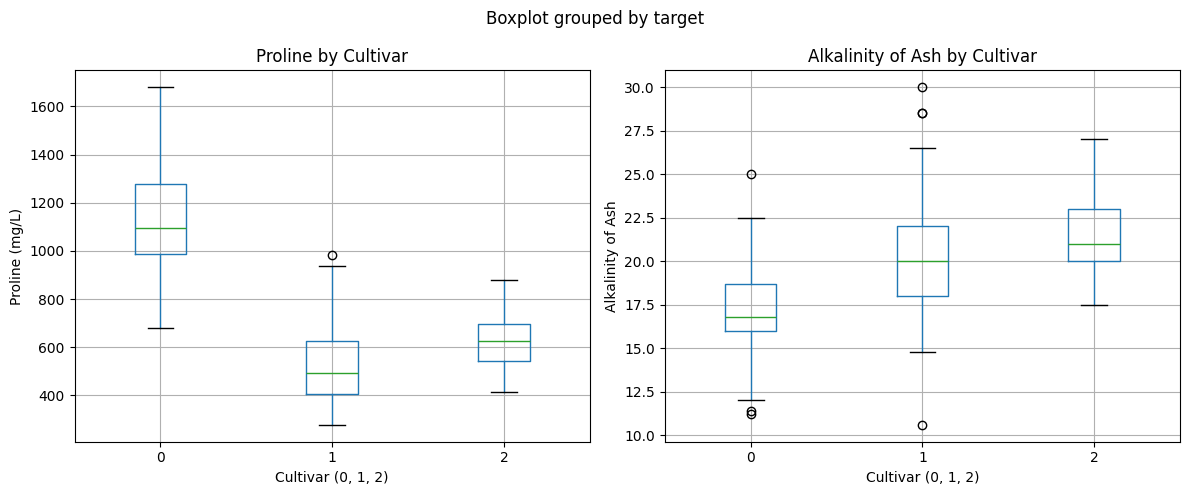

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Proline by cultivar
dataFrame.boxplot(column='proline', by='target', ax=axes[0])
axes[0].set_title('Proline by Cultivar')
axes[0].set_xlabel('Cultivar (0, 1, 2)')
axes[0].set_ylabel('Proline (mg/L)')

# Alkalinity of ash by cultivar
dataFrame.boxplot(column='alcalinity_of_ash', by='target', ax=axes[1])
axes[1].set_title('Alkalinity of Ash by Cultivar')
axes[1].set_xlabel('Cultivar (0, 1, 2)')
axes[1].set_ylabel('Alkalinity of Ash')

plt.tight_layout()
plt.show()

In [10]:
# Create biologically relevant proline bins
dataFrame['proline_bin'] = pd.cut(
    dataFrame['proline'],
    bins=[0, 600, 800, 2000],
    labels=['nutrient_deficiency',
            'nutrient_equilibrium',
            'nutrient_stress']
)

# Verify the distribution
print(dataFrame['proline_bin'].value_counts())

# Check how bins align with cultivars
print(pd.crosstab(dataFrame['proline_bin'], dataFrame['target']))

proline_bin
nutrient_deficiency     71
nutrient_stress         62
nutrient_equilibrium    45
Name: count, dtype: int64
target                 0   1   2
proline_bin                     
nutrient_deficiency    0  50  21
nutrient_equilibrium   6  17  22
nutrient_stress       53   4   5
